# CNN_SignMNIST

>### Load modules

In [5]:
import cv2
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

NumPy Version :1.25.2
TensorFlow Version :2.15.0
Matplotlib Version :3.7.1


> ### Load Data

In [6]:
colab=True
try:
  from google.colab import drive
except:
  colab =False
if colab :
    drive.mount('/content/drive')
    print('g-drive mounted.')
else : print('local drive.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
g-drive mounted.


In [7]:
# file path: 다른 경로에 실습파일을 복사했다면, 아래 경로를 수정하세요

if colab :
  files_path = '/content/drive/MyDrive/files/sign_mnist/'
else :
  files_path = '../files/sign_mnist/'

In [8]:
# csv에서 이미지 읽기
import csv
def get_data(filename):
    with open(filename) as training_file:
        reader = csv.reader(training_file, delimiter=',')
        imgs = []
        labels = []

        next(reader, None)

        for row in reader:
            label = row[0]
            data = row[1:]
            img = np.array(data).reshape((28, 28))

            imgs.append(img)
            labels.append(label)

        images = np.array(imgs).astype(np.float32)
        labels = np.array(labels).astype(np.float32)
    return images, labels

training_data_raw, training_labels_raw = get_data(files_path + 'sign_mnist_train/sign_mnist_train.csv')
testing_data_raw, testing_labels_raw = get_data(files_path + 'sign_mnist_test/sign_mnist_test.csv')

In [112]:
# Print the shapes and first 10 labels of the training and testing data
print("Training data shape:", training_data_raw.shape)
print("Training labels shape:", training_labels_raw.shape)
print("First 10 training labels:", training_labels_raw[:10])
print("Testing data shape:", testing_data_raw.shape)
print("Testing labels shape:", testing_labels_raw.shape)
print("First 10 testing labels:", testing_labels_raw[:10])

Training data shape: (27455, 28, 28)
Training labels shape: (27455,)
First 10 training labels: [ 3.  6.  2.  2. 13. 16.  8. 22.  3.  3.]
Testing data shape: (7172, 28, 28)
Testing labels shape: (7172,)
First 10 testing labels: [ 6.  5. 10.  0.  3. 21. 10. 14.  3.  7.]


In [31]:
def redefine_data(data,labels,selection_list):

    alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    selection_num_list = [alphabets.index(ch) for ch in selection_list.upper()]

    new_data = []
    new_labels = []

    for da, la in zip(data, labels):
        if la in selection_num_list:
            new_data.append(da)
            new_labels.append(selection_num_list.index(la))

    return np.array(new_data), np.array(new_labels)

In [32]:
training_data_selected, training_labels_selected = redefine_data(training_data_raw,training_labels_raw,'ABFVY')
testing_data_selected, testing_labels_selected = redefine_data(testing_data_raw,testing_labels_raw,'ABFVY')

In [33]:
# 1. train_data, train_labels, test_data, test_labels 준비 -> train_data와 test_data는 채널 1개로 변경해야 함

train_data = training_data_selected[..., np.newaxis]
test_data = testing_data_selected[..., np.newaxis]

train_labels = training_labels_selected
test_labels = testing_labels_selected

print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("First 10 train labels:", train_labels[:10])
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("First 10 test labels:", test_labels[:10])

Train data shape: (5540, 28, 28, 1)
Train labels shape: (5540,)
First 10 train labels: [3 4 1 1 0 2 0 3 3 0]
Test data shape: (1688, 28, 28, 1)
Test labels shape: (1688,)
First 10 test labels: [2 0 3 3 0 0 3 1 3 2]


In [34]:
img_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
                horizontal_flip=True,        # 좌우 반전 여부 설정
                rotation_range=0.4,          # 회전 범위 설정
                width_shift_range=0.3,       # 좌우로 이동할 범위 설정
                height_shift_range=0.3,      # 상하로 이동할 범위 설정
                brightness_range=(0.2, 0.7), # 밝기 범위 설정
                zoom_range=0.5               # 줌 범위 설정
                )                            # 이외에도 다양한 설정 가능

train_gen = img_gen_train.flow(train_data, train_labels, seed = 100, shuffle = True)

In [35]:
# 2. 전처리: 0 ~ 1로 변환
train_data_norm = train_data / 255.0
test_data_norm  = test_data / 255.0

In [36]:
# 모델 정의
model = tf.keras.models.Sequential()
IMG_SIZE = 28
# conv 1
model.add(tf.keras.layers.Conv2D(28,1,padding='same',activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# dense layers
model.add(tf.keras.layers.Flatten(name='flatten'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        56        
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 28)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 28)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 5488)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 27445     
                                                                 
Total params: 27501 (107.43 KB)
Trainable params: 27501 (107.43 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [37]:
# 5. Model compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
# 6. Make_Result_Plot() 함수 정의
def Make_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    fig_result, ax_result = plt.subplots(2,5,figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        indicies = np.random.choice(len(label),10, replace=False)
        ax_result[idx//5,idx%5].imshow(data[indicies[idx]],cmap = 'gray')
        ax_result[idx//5,idx%5].set_title("test_data[{}] (label : {} / y : {})".format(indicies[idx], label[indicies[idx]], y_max[indicies[idx]]))

53/53 [==============================] - 0s 2ms/step


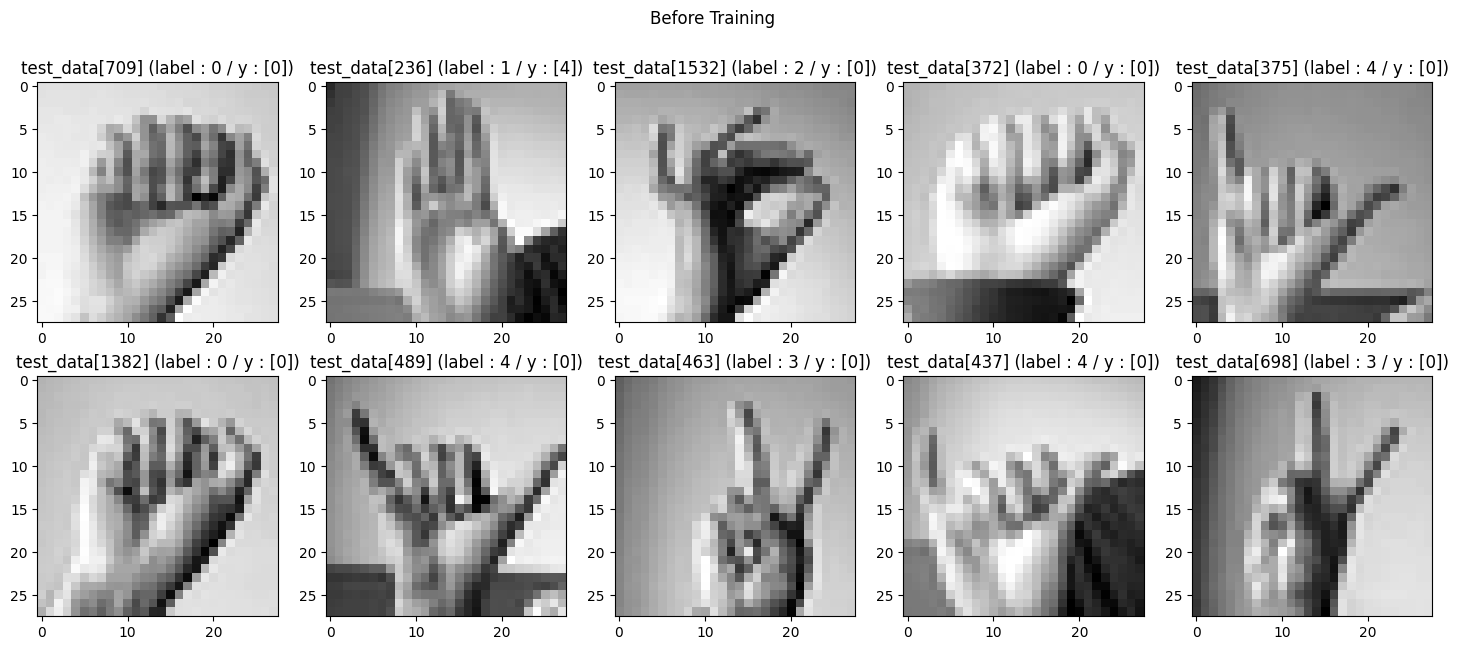

In [49]:
# 7. 학습 전 상황 그리기
y_out = model.predict(test_data_norm)
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("Before Training", test_data, test_labels, y_max)

## Best Model 콜백


In [ ]:
savedModelName = 'EFnet_for_raingame.h5'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(savedModelName,
                                    save_best_only=True)
]

In [ ]:
# 8. Model fit
%%time
history = model.fit(train_data_norm, train_labels, epochs=20,
                 validation_data=(test_data_norm, test_labels), callbacks=callbacks )

In [ ]:
# 9. accuray, loss 그래프 출력
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(6, 10))
plt.subplot(2, 1, 1)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

> ### Training 이후

In [ ]:
# 10. 학습 후 상황 그리기
y_out = model.predict(test_data_norm)
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)

## Best model 백업

In [ ]:
# save_dir: 다른 경로에 저장하려면, 아래 경로를 수정하세요
if colab :
  save_dir = '/content/drive/MyDrive/files/save/'
else :
  save_dir = '../files/save/'

In [ ]:
# copy saved mode
cpCmd = f'cp {savedModelName} {save_dir}'
print(cpCmd)
!{cpCmd}

In [ ]:
model_best = tf.keras.models.load_model(savedModelName)

## TFLite로 전환


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_best)
tflite_model = converter.convert()

In [ ]:
tfliteFileName = 'SignMNIST_Augmentation6.tflite'

In [ ]:
open(save_dir + tfliteFileName, 'ab').write(tflite_model)